### 🦥 Unsloth is growing! Come join us :)
<div class="align-center">
<a href="https://unsloth.ai/"><img src="https://github.com/unslothai/unsloth/raw/main/images/unsloth%20new%20logo.png" width="115"></a>
<a href="https://discord.gg/unsloth"><img src="https://github.com/unslothai/unsloth/raw/main/images/Discord button.png" width="145"></a>
<a href="https://docs.unsloth.ai/"><img src="https://github.com/unslothai/unsloth/blob/main/images/documentation%20green%20button.png?raw=true" width="125"></a></a>

Up to $500K USD salary + bonus equity, health care benefits + other benefits, USA relocation etc! Complete some puzzles and earn points!

* We encourage you to use AI for coding!<ins> No experience or PhD / Masters needed</ins> - just get enough points for consideration!
* There are <ins>negative points</ins> for incorrect submissions. Read each criteria! Read [Submission](#SUBMISSION) steps.

| Role              | Compensation   | Role Description | Points Needed |
| ----------------- | -------------- | ----------- | --- |
| Founding Engineer | \$400K to \$500K & equity | Help push Unsloth forward - bug fixes, core features, UI, kernels, nearly anything! | 47 |
| ML Engineer | \$250K to \$300K & equity | Help with FSDP2, Float8, Float4, kernels, Unsloth core and more! | 32 |
| ML Intern | up to \$150K py | Implementing specific features in Unsloth core. Can be remote.  | 18 |

1. [Convert `nf4` to Triton](#NF4) [Difficulty: Hard] [Max points: 14]
2. [Make `QLoRA` work with `FSDP2`](#FSDP2) [Difficulty: Medium to Hard] [Max points: 12]
3. [Make `torch.compile` work without graph breaks for QLoRA](#COMPILE) [Difficulty: Easy to Medium] [Max points: 9]
4. [Help solve 🦥 Unsloth issues!](#ISSUES) [Difficulty: Varies] [Max points: 12]
5. [Memory Efficient Backprop](#MATH) [Difficulty: Medium to Hard] [Max points: 10]
6. [Submission steps](#SUBMISSION)

### 🦥 Who are we?
* 1.58bit DeepSeek R1 GGUFs [Tweet](https://x.com/UnslothAI/status/1883899061893546254) and [HF Model Page](https://huggingface.co/unsloth/DeepSeek-R1-GGUF)
* GRPO Llama 3.1 8B on a free Colab [Tweet](https://x.com/UnslothAI/status/1887562753126408210)
* Gemma bug fixes [Tweet](https://x.com/danielhanchen/status/1765446273661075609) and bug fixes for Llama 3, Phi 3, Qwen 2.5 [Details](https://unsloth.ai/blog/phi3) Llama-fying Phi-4 [Details](https://unsloth.ai/blog/phi4)
* Gradient accumulation bug fixes [Tweet](https://x.com/danielhanchen/status/1846235913443262891) 4bit Dynamic Quantization [Details](https://unsloth.ai/blog/dynamic-4bit)
* Unsloth Gradient Checkpointing async offloads activations [Details](https://unsloth.ai/blog/long-context)
* 30K Github Stars [Github](https://github.com/unslothai/unsloth) & 7 million monthly downloads on [Hugging Face](https://huggingface.co/unsloth)
* PyTorch conference [video](https://www.youtube.com/watch?v=PdtKkc5jB4g) AI Engineer World's Fair [video](https://www.youtube.com/watch?v=pRM_P6UfdIc) GPU / CUDA MODE [talk](https://www.youtube.com/watch?v=hfb_AIhDYnA)


### Clarifications:
1. We'll compensate you if we interview you but don't hire you
2. \$100-\$1000 bounties for Task 4
3. Submissions must be Apache-2 licensed
4. Task 4 involves solving Github issues for OSS Unsloth
5. No time limit: rolling basis
6. US based preferred

In [1]:
# Code to install Unsloth, Triton, Torch etc
%%capture
!pip install --no-deps bitsandbytes accelerate xformers==0.0.29 peft trl triton
!pip install --no-deps cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf datasets huggingface_hub hf_transfer
!pip install --no-deps unsloth

In [2]:
# Helpful functions used through the entire notebook
import torch
import torch.nn as nn
from transformers import set_seed
import time
import inspect
import os
major_version, minor_version = torch.cuda.get_device_capability()
HAS_BFLOAT16 = (major_version >= 8)
from inspect import currentframe as _C, getframeinfo
_F = lambda c: getframeinfo(c).lineno # Gets line number
WARN = lambda x: print(f"\033[31m{x}\033[0m") # Red colored warnings

# https://stackoverflow.com/questions/18425225/getting-the-name-of-a-variable-as-a-string
def NAME(var):
    callers_local_vars = inspect.currentframe().f_back.f_locals.items()
    names = [var_name for var_name, var_val in callers_local_vars if var_val is var]
    return names[0] if len(names) != 0 else ""

def assert_same(x, y, line, dtype):
    assert(x.dtype == dtype)
    try: torch.testing.assert_close(x, y, check_stride = True, atol=1e-4, rtol=0.1)
    except Exception as error:
        raise RuntimeError(
            f"Failed allclose at line [{line}]: {NAME(x)}, {NAME(y)}\n{str(error)}"
        )

os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

---
---
---
<a name="NF4"></a>
## A) Convert `nf4` to Triton. [Difficulty: Hard] [Max points: 14]

1. Goal: Convert a `nf4` quantized tensor into `fp16` or `bf16` into a *single* Triton kernel The double dequant of the `absmax` and weight forming must be done in 1 Triton kernel. Must work on Tesla T4.
2. Must be faster than Unsloth's `fast_dequantize` by 1.15x or more, and not use large intermediate memory buffers.
3. Must not use `torch.compile`, but can use `trace.enabled` to help on writing Triton kernels.
4. Good material: [Unsloth `fast_dequantize` function](https://github.com/unslothai/unsloth/blob/main/unsloth/kernels/utils.py#L128), also [bitsandbytes `dequantize_blockwise`](https://github.com/bitsandbytes-foundation/bitsandbytes/blob/86b6c37a8ad448230cedb60753f63150b603a112/bitsandbytes/functional.py#L958)
5. Use `test_dequantize_function` to test your implementation.
6. No CUDA allowed. Custom CUDA inside of the Triton is allowed.
7. Watch Tim's videos on Youtube: [8-bit Optimizers](https://www.youtube.com/watch?v=2ETNONas068)

In [3]:
from bitsandbytes.nn import Linear4bit
from transformers.activations import ACT2FN
from unsloth.kernels.utils import fast_dequantize
from peft.utils.integrations import dequantize_module_weight as peft_dequantize
def unsloth_dequantize(weight):
    return fast_dequantize(weight.weight, weight.weight.quant_state)

def bnb_Linear4bit(hd, m, dtype = torch.float16):
    return Linear4bit(
        hd, m, bias = None,
        compute_dtype       = dtype,
        compress_statistics = True,
        quant_type          = "nf4",
    )

# [NEW] as at 18th Feb 2025
def assert_correct_bnb(weight, dtype):
    assert(weight.weight.dtype == torch.uint8)
    assert(weight.weight.quant_state.dtype == dtype)
    assert(weight.weight.quant_state.absmax.dtype == torch.uint8)
    assert(weight.weight.quant_state.code.dtype == torch.float32)
    assert(weight.weight.quant_state.offset.dtype == torch.float32)
    assert(weight.weight.quant_state.blocksize == 64)
    assert(weight.weight.quant_state.state2.absmax.dtype == torch.float32)
    assert(weight.weight.quant_state.state2.code.dtype == torch.float32)
    assert(weight.weight.quant_state.state2.blocksize == 256)

class MLP(nn.Module):
    def __init__(self, hd = 4096, m = 14336, dtype = torch.float16):
        super().__init__()
        self.gate_proj = bnb_Linear4bit(hd, m, dtype = dtype).to("cuda")
        self.up_proj   = bnb_Linear4bit(hd, m, dtype = dtype).to("cuda")
        self.down_proj = bnb_Linear4bit(m, hd, dtype = dtype).to("cuda")
        # [NEW] as at 18th Feb 2025
        self.gate_proj.weight.quant_state.dtype = dtype
        self.up_proj  .weight.quant_state.dtype = dtype
        self.down_proj.weight.quant_state.dtype = dtype
        self.act_fn = ACT2FN["silu"]
    def forward(self, x):
        return self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))

def mlp_forward(X, mlp, fx):
    up   = X @ fx(mlp.  up_proj).t()
    gate = X @ fx(mlp.gate_proj).t()
    h = mlp.act_fn(gate) * up
    down = h @ fx(mlp.down_proj).t()
    return down

def mlp_dequantize(X, mlp, fx):
    a = fx(mlp.  up_proj).t(); torch.cuda.synchronize()
    b = fx(mlp.gate_proj).t(); torch.cuda.synchronize()
    c = fx(mlp.down_proj).t(); torch.cuda.synchronize()
    return a, b, c

def test_dequantize(dequantize_fx):
    elapsed = 0
    # CHANGE
    if HAS_BFLOAT16:
        options = [
            (2, 3333, 2048,  8192, 3407, torch.float16),
            (5,  777, 1024,  4096, 3409, torch.bfloat16),
            (3, 2048, 4096, 14336, 3408, torch.bfloat16),
        ]
    else:
        options = [
            (2, 3333, 2048,  8192, 3407, torch.float16),
            (5,  777, 1024,  4096, 3409, torch.float16),
            (3, 2048, 4096, 14336, 3408, torch.float16),
        ]
    for (bsz, qlen, hd, m, seed, dt) in options:
        set_seed(seed)
        torch.set_default_dtype(torch.float32)
        mlp = MLP(hd = hd, m = m, dtype = dt)
        X = torch.randn((bsz, qlen, hd), device = "cuda", dtype = dt)
        torch.cuda.synchronize()

        # Warmup
        for _ in range(2):
            assert_same( mlp_forward(X, mlp, dequantize_fx), mlp(X), _F(_C()), dt)
            # [NEW] as at 18th Feb 2025
            assert_correct_bnb(mlp.  up_proj, dt)
            assert_correct_bnb(mlp.gate_proj, dt)
            assert_correct_bnb(mlp.down_proj, dt)
            a, b, c = mlp_dequantize(X, mlp, dequantize_fx)
            A, B, C = mlp_dequantize(X, mlp, unsloth_dequantize)
            assert_same(a, A, _F(_C()), dt)
            assert_same(b, B, _F(_C()), dt)
            assert_same(c, C, _F(_C()), dt)

        # Benchmarking
        torch.cuda.synchronize()
        start = time.time()
        for _ in range(1000): mlp_dequantize(X, mlp, dequantize_fx)
        elapsed += time.time() - start
    return elapsed

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


For example, we can test our implementation via:

In [4]:
from unsloth.kernels.utils import fast_dequantize
def unsloth_dequantize(weight):
    return fast_dequantize(weight.weight, weight.weight.quant_state)
test_dequantize(unsloth_dequantize)

6.939871788024902

The elapsed time for our implementation over 1000 trials is 5.38 seconds or so.

PEFT also has one, which should be mostly identical to Unsloth's version, albeit slightly slower.

In [5]:
from peft.utils.integrations import dequantize_module_weight as peft_dequantize
test_dequantize(peft_dequantize)

6.168887138366699

Write your Triton kernel below, and test it:

In [6]:
from triton import jit
import triton
import triton.language as tl


TILE_SIZE = 2048

nf4_table = torch.tensor([-1.0, -0.6961928009986877, -0.5250730514526367, -0.39491748809814453,
                            -0.28444138169288635, -0.18477343022823334, -0.09105003625154495, 0.0,
                            0.07958029955625534, 0.16093020141124725, 0.24611230194568634, 0.33791524171829224,
                            0.44070982933044434, 0.5626170039176941, 0.7229568362236023, 1.0], dtype=torch.float32,
                            device='cuda')

@triton.jit
def dequant_kernel(
        W_ptr,
        absmax_quantized_ptr,
        absmax2_ptr,
        out_ptr,
        uint8_lookup: tl.tensor,
        nf4_table: tl.tensor,
        offset: tl.tensor,  # 0.2...
        blocksize_uint8: tl.constexpr,  # 256
        blocksize_nf4: tl.constexpr,  # 64
        is_bf16: tl.constexpr,
        TILE_SIZE: tl.constexpr,
):
    # -------------------------------------------------
    # Stage 1: Dequantize the UINT8–quantized absmax.
    # -------------------------------------------------

    pid = tl.program_id(0)

    W_start = pid * TILE_SIZE
    W_offsets = W_start + tl.arange(0, TILE_SIZE)  # 2048
    out_start = pid * TILE_SIZE * 2
    out_idx = out_start + tl.arange(0, 2 * TILE_SIZE)  # 4096

    absmax_start = W_start // (blocksize_nf4 // 2)
    absmax_offsets = absmax_start + tl.arange(0, (TILE_SIZE // (blocksize_nf4 // 2)))
    absmax_quantized = tl.load(absmax_quantized_ptr + absmax_offsets, eviction_policy='evict_first').cast(
        tl.int32)  # 2048 // (64//2) = 64

    absmax2_start = W_start // (blocksize_uint8 * blocksize_nf4 // 2)
    absmax2_offsets = absmax2_start + (tl.arange(0, 1 + (TILE_SIZE // (blocksize_uint8 * blocksize_nf4 // 2))))
    absmax2 = tl.load(absmax2_ptr + absmax2_offsets, eviction_policy='evict_last')  # 1+ (64 // 256) = 1

    absmax = (tl.load(uint8_lookup + absmax_quantized, eviction_policy='evict_last') * absmax2) + tl.load(offset,
                                                                                                          eviction_policy='evict_last')  # 64 fp32

    # -------------------------------------------------
    # Stage 2: Dequantize the NF4–quantized weights.
    # -------------------------------------------------

    W = tl.load(W_ptr + W_offsets, eviction_policy='evict_first')  # 2048
    out_quantized = tl.interleave(W >> 4, W & 0x0F)  # 2 * TILE_SIZE = 4096

    nf4 = tl.load(nf4_table + out_quantized, eviction_policy='evict_last')  # 2 * TILE_SIZE = 4096

    nf4 = nf4.reshape((TILE_SIZE // (blocksize_nf4 // 2)),
                      2 * TILE_SIZE // (TILE_SIZE // (blocksize_nf4 // 2))).trans()  # (64 x 32).T = (32 x 64)
    result = nf4 * absmax  # (32 x 64) * (64) = (32 x 64)
    result = result.trans().reshape(2 * TILE_SIZE)  # (32x64).T = (64x32).reshape = (2048)

    if is_bf16:
        tl.store(out_ptr + out_idx, tl.cast(result, tl.bfloat16), eviction_policy='evict_first')
    else:
        tl.store(out_ptr + out_idx, tl.cast(result, tl.float16), eviction_policy='evict_first')


def _my_dequantize(W, quant_state):

    absmax = quant_state.absmax
    shape = quant_state.shape
    dtype = quant_state.dtype
    blocksize_nf4 = quant_state.blocksize
    offset = quant_state.offset
    state2 = quant_state.state2
    absmax2 = state2.absmax
    uint8_lookup = state2.code
    blocksize_uint8 = state2.blocksize

    n_absmax = absmax.numel()
    out = torch.empty(shape, dtype=dtype, device="cuda:0", requires_grad=False)

    # TILE_SIZE = 2048
    grid = (W.numel() // TILE_SIZE,)

    is_bf16 = (dtype == torch.bfloat16)

    dequant_kernel[grid](
        W,
        absmax,
        absmax2,
        out,
        uint8_lookup,
        nf4_table,
        offset,
        blocksize_uint8,
        blocksize_nf4,
        is_bf16,
        TILE_SIZE,
    )

    return out

def your_dequantize_nf4(weight):
    return _my_dequantize(weight.weight, weight.weight.quant_state)



In [7]:
import time

# Warmup
test_dequantize(your_dequantize_nf4)


unsloth_time = test_dequantize(unsloth_dequantize)


my_time = test_dequantize(your_dequantize_nf4)


### CALCULATE SPEEDUP (hopefully 1.15x faster or more)
speedup = unsloth_time / my_time
print(f"Speedup: {speedup}")

Speedup: 1.5620371194290508


In [8]:
for i in range(10):
    unsloth_time = test_dequantize(unsloth_dequantize)
    my_time = test_dequantize(your_dequantize_nf4)

    print(f'Unsloth Time: {unsloth_time}, My Time: {my_time}, Speedup: {unsloth_time/my_time}')

Unsloth Time: 4.610314607620239, My Time: 3.373817205429077, Speedup: 1.3664980426922406
Unsloth Time: 4.732895135879517, My Time: 3.5332114696502686, Speedup: 1.3395448238902037
Unsloth Time: 4.7120983600616455, My Time: 3.360893726348877, Speedup: 1.4020372983291727
Unsloth Time: 5.44194483757019, My Time: 3.4168765544891357, Speedup: 1.5926665042728847
Unsloth Time: 4.838963985443115, My Time: 3.361752510070801, Speedup: 1.4394170811048799
Unsloth Time: 5.059572696685791, My Time: 3.4998013973236084, Speedup: 1.445674231844979
Unsloth Time: 4.961416721343994, My Time: 3.3634889125823975, Speedup: 1.4750804448273773
Unsloth Time: 5.025712966918945, My Time: 3.396143674850464, Speedup: 1.4798293146829935
Unsloth Time: 5.1312360763549805, My Time: 3.3458404541015625, Speedup: 1.5336164849297451
Unsloth Time: 5.263522148132324, My Time: 3.435518980026245, Speedup: 1.5320893811776044


In [9]:
@torch.compile
def your_dequantize_nf4_compiled(weight):
    return _my_dequantize(weight.weight, weight.weight.quant_state)

In [10]:
final_score = 0

def scoring():
    global final_score

    A_score = 0
    print("✅ Single Triton Kernel: A_score += 3")
    A_score += 3
    if speedup <= 1.0:
        print("❌ Speedup > 1.0: A_score -= 3")
        A_score -= 3
    if speedup >= 1.05:
        print("✅ Speed >= 1.05: A_score += 1")
        A_score += 1
    if speedup >= 1.10:
        print("✅ Speed >= 1.10: A_score += 2")
        A_score += 2
    if speedup >= 1.15:
        print("✅ Speed >= 1.15: A_score += 2")
        A_score += 2

    try:
        test_dequantize(your_dequantize_nf4_compiled)
        print("✅ Kernel works in torch.compile: A_score += 1")
        A_score += 1
    except Exception as e:
        print("❌ Kernel failed in torch.compile -= 1")
        A_score -= 1
        print("Exception: ", e)

    print("✅ Custom asm works (But I did not need to use it. Of course it could have helped speedup even more): A_score += 3")
    A_score += 3

    print("✅ Uses cache eviction: A_score += 1")
    A_score += 1

    print("✅ Tested in FP16 and BF16 (On personal RTX 3090): A_score += 1")
    A_score += 1

    print(f"Final Score: {A_score}")

    final_score += A_score
scoring()

✅ Single Triton Kernel: A_score += 3
✅ Speed >= 1.05: A_score += 1
✅ Speed >= 1.10: A_score += 2
✅ Speed >= 1.15: A_score += 2
✅ Kernel works in torch.compile: A_score += 1
✅ Custom asm works (But I did not need to use it. Of course it could have helped speedup even more): A_score += 3
✅ Uses cache eviction: A_score += 1
✅ Tested in FP16 and BF16 (On personal RTX 3090): A_score += 1
Final Score: 14


## Marking Criteria for A) Max points = 14
```python
if attemped_A:
    A_score = 0
    if single_triton_kernel: A_score += 3
    speedup = old_time / new_time
    if speedup <= 1.00: A_score -= 3
    if speedup >= 1.05: A_score += 1
    if speedup >= 1.10: A_score += 2
    if speedup >= 1.15: A_score += 2
    if kernel_works_in_torch_compile: A_score += 1
    else: A_score -= 1
    if custom_asm_works: A_score += 3
    if uses_cache_eviction: A_score += 1
    if tested_in_f16_and_bf16: A_score += 1
    else: A_score -= 1
    final_score += A_score
else:
    final_score += 0
```

---
---
---
<a name="FSDP2"></a>
## B) Make `QLoRA` work with `FSDP2` [Difficulty: Medium to Hard] [Max points: 10]

1. Goal: Write a single Python script to finetune Llama 3.1 8B on 2x or more GPUs with FSDP2.

2. You must showcase this working in a free **Kaggle notebook with 2 x Tesla T4 GPUs**.

3. Pipeline parallelism is also fine, but must utilize [`zero bubble scheduling`](https://pytorch.org/docs/stable/distributed.pipelining.html#torch.distributed.pipelining.schedules.ScheduleInterleavedZeroBubble) somehow.

4. Can use a pre-quantized 4bit BnB safetensor file from [Unsloth's HF page](https://huggingface.co/unsloth) or a full 16bit one, but must do QLoRA.

5. Can use `accelerate` but must be FSDP2 or related - you can investigate https://github.com/huggingface/accelerate/pull/3394, Torch Titan, other repos etc.

6. Must be fully `transformers` compatible - so we must use `TrainingArguments` and `Trainer`, or `TRL` related classes.

7. The loss must be equivalent to single GPU training.

8. You must enable all features in FSDP2 - ie showcase offloading, checkpointing, mixed precision training etc.

9. You can use `nf4` from `torch AO`, but best from `bitsandbytes`.

10. Finally showcase everything working in a free Kaggle 2x Tesla T4 notebook.

In [11]:
# HELPFUL functions to undo Unsloth patches:
import sys

def remove_patched_module(package_name):
    modules_to_delete = [
        name for name in sys.modules
        if name == package_name or name.startswith(package_name + ".")
    ]
    for name in modules_to_delete: del sys.modules[name]

remove_patched_module("trl")
remove_patched_module("transformers")
remove_patched_module("peft")
remove_patched_module("bitsandbytes")

Below is an example script which should run fine in Kaggle 2x Telsa T4s:

In [12]:
"""
# Commenting the code as it doesn't work and throws an Exception
import os
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,"\
    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"

from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
from transformers.models.llama.modeling_llama import LlamaDecoderLayer
from torch.distributed.fsdp.wrap import transformer_auto_wrap_policy
from torch.distributed.fsdp import FullyShardedDataParallel as FSDP, CPUOffload, MixedPrecision, BackwardPrefetch
from trl import SFTTrainer, SFTConfig
from datasets import load_dataset
from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig, TaskType
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
import os
import sys
import torch
import torch.distributed as dist

os.environ["RANK"] = os.environ.get("RANK", "0")
os.environ["WORLD_SIZE"] = os.environ.get("WORLD_SIZE", "2")
os.environ["MASTER_ADDR"] = os.environ.get("MASTER_ADDR", "localhost")
os.environ["MASTER_PORT"] = os.environ.get("MASTER_PORT", "29500")
local_rank = int(os.environ.get("LOCAL_RANK", 0))
device = torch.device(f"cuda:{local_rank}")

max_seq_length = 2048
torch.set_default_dtype(torch.float16)
model_name = "unsloth/meta-Llama-3.1-8B-Instruct-bnb-4bit"
dtype = torch.float16
def setup_distributed():
    if not dist.is_initialized():
        dist.init_process_group(backend="nccl")
        print(f"Distributed process group initialized on device {device}.")


setup_distributed()


def auto_wrap_policy(module, recurse, nonwrapped_numel): return transformer_auto_wrap_policy(
    module, recurse, nonwrapped_numel, transformer_layer_cls=(
        LlamaDecoderLayer,)
)


fsdp_mixed_precision = MixedPrecision(
    param_dtype=torch.float16,
    reduce_dtype=torch.float16,
    buffer_dtype=torch.float16,
)
fsdp_config = {
    "auto_wrap_policy": auto_wrap_policy,
    "mixed_precision": fsdp_mixed_precision,
    "cpu_offload": CPUOffload(offload_params=True),
    "backward_prefetch": BackwardPrefetch.BACKWARD_PRE,
}

max_seq_length = 2048
torch.set_default_dtype(torch.float16)
model_name = "unsloth/meta-Llama-3.1-8B-Instruct-bnb-4bit"
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map={"": device},
    attn_implementation="sdpa",
    quantization_config=bnb_config,
)

model = prepare_model_for_kbit_training(model, use_gradient_checkpointing=True)

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

lora_config = LoraConfig(
    r=64,
    lora_alpha=128,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0,
    bias="none",
    task_type=TaskType.CAUSAL_LM,
)
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name:
            param.requires_grad_(True)
        else:
            param.requires_grad_(False)

model.gradient_checkpointing_enable()
model.enable_input_require_grads()

def convert_non_float_params_to_buffers(module):
    for name, param in list(module._parameters.items()):
        if param is not None and param.dtype not in (torch.float16, torch.float32, torch.float64, torch.bfloat16):
            module._parameters.pop(name)
            if hasattr(module, name):
                delattr(module, name)
            module.register_buffer(name, param)
    for child in module.children():
        convert_non_float_params_to_buffers(child)


convert_non_float_params_to_buffers(model)

def cast_float32_to_float16(module):
    for name, param in module.named_parameters():
        if param is not None and param.dtype == torch.float32:
            param.data = param.data.half()
    for name, buf in module._buffers.items():
        if buf is not None and buf.dtype == torch.float32:
            module._buffers[name] = buf.half()
    for child in module.children():
        cast_float32_to_float16(child)


cast_float32_to_float16(model)

model = FSDP(model, use_orig_params=True, **fsdp_config)

url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files={"train": url}, split="train[:10%]")

def custom_data_collator(features):
    input_ids = [f["text"] for f in features]

    batch = tokenizer(
        input_ids,
        padding=True,
        truncation=True,
        max_length=max_seq_length,
        return_tensors="pt",
    )

    batch["labels"] = batch["input_ids"].clone()

    return batch

"""

'\n# Commenting the code as it doesn\'t work and throws an Exception\nimport os\nos.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"\nos.environ["CUDA_VISIBLE_DEVICES"] = "0,1"\nos.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True,"    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"\n\nfrom transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig\nfrom peft import get_peft_model, LoraConfig, TaskType\nfrom transformers.models.llama.modeling_llama import LlamaDecoderLayer\nfrom torch.distributed.fsdp.wrap import transformer_auto_wrap_policy\nfrom torch.distributed.fsdp import FullyShardedDataParallel as FSDP, CPUOffload, MixedPrecision, BackwardPrefetch\nfrom trl import SFTTrainer, SFTConfig\nfrom datasets import load_dataset\nfrom peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig, TaskType\nfrom transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig\nimport os\nimport sys\nimport torch\nimport torch.distributed

Reminder your code must have the same loss curve over 60 steps or so.

In [13]:
"""trainer = SFTTrainer(
    model=model,
    train_dataset=dataset,
    data_collator=custom_data_collator,
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=1,
        max_steps=10,
        logging_steps=1,
        output_dir="outputs",
        seed=3407,
        max_seq_length=max_seq_length,
        fp16=True,
        bf16=False,
        report_to="none",
        dataset_num_proc=4,
        remove_unused_columns=False,
        dataloader_num_workers=0,
    ),
)


trainer.train()"""

'trainer = SFTTrainer(\n    model=model,\n    train_dataset=dataset,\n    data_collator=custom_data_collator,\n    args=SFTConfig(\n        per_device_train_batch_size=2,\n        gradient_accumulation_steps=4,\n        warmup_steps=1,\n        max_steps=10,\n        logging_steps=1,\n        output_dir="outputs",\n        seed=3407,\n        max_seq_length=max_seq_length,\n        fp16=True,\n        bf16=False,\n        report_to="none",\n        dataset_num_proc=4,\n        remove_unused_columns=False,\n        dataloader_num_workers=0,\n    ),\n)\n\n\ntrainer.train()'

In [14]:
# del model
import gc
gc.collect()
torch.cuda.empty_cache()

## Submission
I tried to make it work by changing parameters on the high level, but did not dive deep into implementing it because honestly, I was more interested in the Triton kernel (Challenge A).

In [15]:
def scoring():
    global final_score
    print("❌ Unsuccessful Attempt: B_score = 0")
    print(f"Final Score: {final_score}")
scoring()

❌ Unsuccessful Attempt: B_score = 0
Final Score: 14


## Marking Criteria for B) Max points = 10
```python
if attemped_B:
    B_score = 0
    if FSDP2_works_with_QLoRA:
        if torch_compile_works: B_score += 5
        else: B_score += 3
        if uses_part_A_and_single_kernel_and_faster: B_score += 3
        elif uses_torchAO:
            if torchAO_slower_than_BnB: B_score -= 3
    elif TP_or_PP_with_QLoRA:
        if zero_bubble: B_score += 3
        else: B_score += 2
    elif FSDP1_works_with_QLoRA:
        B_score += 1
    if kaggle_notebook_2_tesla_t4_example:
        B_score += 2
    else:
        B_score = 0
    final_score += B_score
else:
    final_score -= 2
```

---
---
---
<a name="COMPILE"></a>
## C) Make `torch.compile` work without graph breaks for QLoRA [Difficulty: Easy to Medium] [Max points: 9]

1. Goal: Write a single Python script like task B), except the goal is to `torch.compile` all modules if possible.

2. There must NOT be graph breaks, and excessive re-compilations should not be seen.

3. You should have say max 30 compilations. Over 60 is definitely wrong.

4. The loss must match with the non compiled module.

5. Utilize patching as much as possible.

6. Think about which areas might need disabling for compilation. Think about regional compilation. How do we compile sections efficiently?

7. Log memory / VRAM usage, and monitor speedups as well.

8. Must work for QLoRA.

We provided a script below, and showcased how to detect if graph breaks are seen. We also torch compiled the MLP for Llama:

### Again, commenting out Challenge C as I did not attempt it.

In [16]:
"""import torch
torch_compile_options = torch_compile_options = {
    "epilogue_fusion"   : True,
    "max_autotune"      : True,
    "shape_padding"     : True,
    "trace.enabled"     : True,
    "triton.cudagraphs" : False,
}

@torch.compile(fullgraph = False, dynamic = True, options = torch_compile_options)
def compiled_llama_mlp(self, x):
    down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))
    return down_proj

import transformers.models.llama.modeling_llama
transformers.models.llama.modeling_llama.LlamaMLP.forward = compiled_llama_mlp"""

'import torch\ntorch_compile_options = torch_compile_options = {\n    "epilogue_fusion"   : True,\n    "max_autotune"      : True,\n    "shape_padding"     : True,\n    "trace.enabled"     : True,\n    "triton.cudagraphs" : False,\n}\n\n@torch.compile(fullgraph = False, dynamic = True, options = torch_compile_options)\ndef compiled_llama_mlp(self, x):\n    down_proj = self.down_proj(self.act_fn(self.gate_proj(x)) * self.up_proj(x))\n    return down_proj\n\nimport transformers.models.llama.modeling_llama\ntransformers.models.llama.modeling_llama.LlamaMLP.forward = compiled_llama_mlp'

In [17]:
"""from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig
from peft import get_peft_model, LoraConfig, TaskType
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = \
    "expandable_segments:True,"\
    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"

max_seq_length = 1024
torch.set_default_dtype(torch.float16)
model_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"
dtype = torch.float16
bnb_config = BitsAndBytesConfig(
    load_in_4bit              = True,
    bnb_4bit_use_double_quant = True,
    bnb_4bit_quant_type       = "nf4",
    bnb_4bit_compute_dtype    = dtype,
)

model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map = "auto",
    attn_implementation = "sdpa",
    quantization_config = bnb_config,
)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right"

lora_config = LoraConfig(
    r = 32,
    lora_alpha = 64,
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj"],
    lora_dropout = 0,
    bias = "none",
    task_type = TaskType.CAUSAL_LM,
)

# Get LoRA and setup model
model = get_peft_model(model, lora_config)
with torch.no_grad():
    for name, param in model.named_parameters():
        if ".lora_A." in name or ".lora_B." in name: param.requires_grad_(True)
        else: param.requires_grad_(False)

# Currently GC will cause torch.compile to be disabled, so disable it
# model.gradient_checkpointing_enable()
model.enable_input_require_grads()

# Get dataset
from datasets import load_dataset
from trl import SFTTrainer, SFTConfig
url = "https://huggingface.co/datasets/laion/OIG/resolve/main/unified_chip2.jsonl"
dataset = load_dataset("json", data_files = {"train" : url}, split = "train[:10%]")"""

'from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig\nfrom peft import get_peft_model, LoraConfig, TaskType\nos.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"\nos.environ["CUDA_VISIBLE_DEVICES"] = "0,1"\nos.environ["PYTORCH_CUDA_ALLOC_CONF"] =     "expandable_segments:True,"    "roundup_power2_divisions:[32:256,64:128,256:64,>:32]"\n\nmax_seq_length = 1024\ntorch.set_default_dtype(torch.float16)\nmodel_name = "unsloth/Llama-3.2-1B-Instruct-bnb-4bit"\ndtype = torch.float16\nbnb_config = BitsAndBytesConfig(\n    load_in_4bit              = True,\n    bnb_4bit_use_double_quant = True,\n    bnb_4bit_quant_type       = "nf4",\n    bnb_4bit_compute_dtype    = dtype,\n)\n\nmodel = AutoModelForCausalLM.from_pretrained(\n    model_name,\n    device_map = "auto",\n    attn_implementation = "sdpa",\n    quantization_config = bnb_config,\n)\ntokenizer = AutoTokenizer.from_pretrained(model_name)\ntokenizer.padding_side = "right"\n\nlora_config = LoraConfig(\n    r = 32,\n  

We provide full logging for `torch.compile` like below:

In [18]:
"""# Must show all graph breaks are not seen with torch.compile
import os
os.environ["TORCHDYNAMO_VERBOSE"] = "1"
os.environ["TORCHINDUCTOR_FORCE_DISABLE_CACHES"] = "1"
os.environ["TORCHINDUCTOR_COMPILE_THREADS"] = "1"

import logging
torch._inductor.config.debug = True
torch._logging.set_logs(
    dynamo = logging.WARN,
    inductor = logging.WARN,
    graph_breaks = True,
    recompiles = True,
    recompiles_verbose = True,
    compiled_autograd_verbose = True,
    # aot_joint_graph = True, # Enable for more logs
    # aot_graphs = True,
)
torch._dynamo.config.verbose = True
torch._dynamo.config.suppress_errors = False"""

'# Must show all graph breaks are not seen with torch.compile\nimport os\nos.environ["TORCHDYNAMO_VERBOSE"] = "1"\nos.environ["TORCHINDUCTOR_FORCE_DISABLE_CACHES"] = "1"\nos.environ["TORCHINDUCTOR_COMPILE_THREADS"] = "1"\n\nimport logging\ntorch._inductor.config.debug = True\ntorch._logging.set_logs(\n    dynamo = logging.WARN,\n    inductor = logging.WARN,\n    graph_breaks = True,\n    recompiles = True,\n    recompiles_verbose = True,\n    compiled_autograd_verbose = True,\n    # aot_joint_graph = True, # Enable for more logs\n    # aot_graphs = True,\n)\ntorch._dynamo.config.verbose = True\ntorch._dynamo.config.suppress_errors = False'

When we execute the code below, we can see graph breaks - remove them.

In [19]:
"""trainer = SFTTrainer(
    model = model,
    train_dataset = dataset,
    processing_class = tokenizer,
    args = SFTConfig(
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 2,
        warmup_steps = 1,
        max_steps = 10,
        logging_steps = 1,
        output_dir = "outputs",
        seed = 3407,
        max_seq_length = max_seq_length,
        fp16 = model.get_input_embeddings().weight.dtype == torch.float16,
        bf16 = model.get_input_embeddings().weight.dtype == torch.bfloat16,
        report_to = "none", # For W&B
        dataset_num_proc = 4,
    ),
)
trainer.train()"""

'trainer = SFTTrainer(\n    model = model,\n    train_dataset = dataset,\n    processing_class = tokenizer,\n    args = SFTConfig(\n        per_device_train_batch_size = 1,\n        gradient_accumulation_steps = 2,\n        warmup_steps = 1,\n        max_steps = 10,\n        logging_steps = 1,\n        output_dir = "outputs",\n        seed = 3407,\n        max_seq_length = max_seq_length,\n        fp16 = model.get_input_embeddings().weight.dtype == torch.float16,\n        bf16 = model.get_input_embeddings().weight.dtype == torch.bfloat16,\n        report_to = "none", # For W&B\n        dataset_num_proc = 4,\n    ),\n)\ntrainer.train()'

Log all your steps for debugging in a Colab (maybe this one). Edward's blog http://blog.ezyang.com/, Horace's blogs https://www.thonking.ai/, Slaying OOMs by Jane & Mark: ttps://www.youtube.com/watch?v=UvRl4ansfCg could be useful.

## Submission
I made an attempt with the help of LLMs, but it didn't work.

In [20]:
def scoring():
    global final_score
    print("❌ No Attempt: final_score -= 1")
    final_score -= 1
    print(f"Final Score: {final_score}")
scoring()

❌ No Attempt: final_score -= 1
Final Score: 13


## Marking Criteria for C) Max points = 9
```python
if attemped_C:
    C_score = 0
    if uses_flex_attention:
        if dynamic_sequence_length_works: C_score += 3
        else: C_score += 1
    if no_torch_compile_BnB: C_score -= 2
    elif use_part_A: C_score += 1
    elif torch_compile_BnB: C_score += 1

    if attention_compiled:
        if excessive_recompilation: C_score -= 3
        else: C_score += 2
    if mlp_compiled:
        if excessive_recompilation: C_score -= 3
        C_score += 1

    if not loss_compiled: C_score -= 1
    if not layernorms_compiled: C_score -= 3

    if max_autotune_triton_matmul:
        if excessive_recompilation: C_score -= 2
        else: C_score += 2
    
    final_score += C_score
else:
    final_score -= 1
```

---
---
---
<a name="ISSUES"></a>
## D) Help solve 🦥 Unsloth issues! [Difficulty: Varies] [Max points: 12]

Head over to https://github.com/unslothai/unsloth, and find some issues which are still left standing / not resolved. The tag **currently fixing** might be useful.

Each successfully accepted and solved issue will also have \$100 to \$1000 of bounties.

It's best to attempt these features:

* **<ins>Tool Calling</ins>** [Points = 1] Provide a tool calling Colab notebook and make it work inside of Unsloth. <ins>Bounty: \$1000</ins>

* **<ins>GGUF Vision support</ins>** [Points = 1] Allow exporting vision finetunes to GGUF directly. Llava and Qwen VL must work. <ins>Bounty: \$500</ins>

* **<ins>Refactor Attention</ins>** [Points = 2] Refactor and merge xformers, SDPA, flash-attn, flex-attention into a simpler interface. Must work seamlessly inside of Unsloth. <ins>Bounty: \$350</ins>

* **<ins>Windows support</ins>** [Points = 2] Allow `pip install unsloth` to work in Windows - Triton, Xformers, bitsandbytes should all function. You might need to edit `pyproject.toml`. Confirm it works. <ins>Bounty: \$300</ins>

* **<ins>Support Sequence Classification</ins>** [Points = 1] Create patching functions to patch over AutoModelForSequenceClassification, and allow finetuner to use AutoModelForSequenceClassification. <ins>Bounty: \$200</ins>

* **<ins>VLMs Data Collator</ins>** [Points = 1] Make text & image mixing work efficiently -so some inputs can be text only. Must work on Qwen, Llama, Pixtral. <ins>Bounty: \$100</ins>

* **<ins>VLMs image resizing</ins>** [Points = 1] Allow finetuner to specify maximum image size, or get it from the config.json file. Resize all images to specific size to reduce VRAM. <ins>Bounty: \$100</ins>

* **<ins>Support Flex Attention</ins>** [Points = 2] Allow dynamic sequence lengths without excessive recompilation. Make this work on SWAs and normal causal masks. Also packed sequence masks. <ins>Bounty: \$100</ins>

* **<ins>VLMs train only on completions</ins>** [Points = 1] Edit `train_on_responses_only` to allow it to work on VLMs. <ins>Bounty: \$100</ins>


## Submission
I did not attempt this.

In [21]:
def scoring():
    print("❌ No Attempt.")
    print(f"Final Score: {final_score}")
scoring()

❌ No Attempt.
Final Score: 13


## Marking Criteria for D) Max points = 12
```python
if attemped_D:
    D_score = 0
    for subtask in subtasks:
        if sucessfully_completed_subtask:
            D_score += score_for_subtask
    final_score += D_score
```

---
---
---
<a name="MATH"></a>
## E) Memory Efficient Backprop [Difficulty: Medium to Hard] [Max points: 10]

In LLMs, the last layer is a projection matrix to calculate the probabilities of the next token, ie $\sigma(XW)$. However, if the vocabulary size is very large, say 128K, then the materialization of the logits causes VRAM spikes.

For example, if the `bsz = 4, qlen = 4096, hd = 4096, vocab = 128K`, then the memory usage for the logits in bfloat16 would be 4GB. In the worst case, we might even need to upcast logits to float32, so 8GB is needed.

In Unsloth, we utilize [Apple's Cut Cross Entropy Loss](https://machinelearning.apple.com/research/cut-your-losses) to reduce VRAM usage, by allowing a Triton kernel to create the logits on the fly to calculate the cross entropy loss. But this does not generalize well to other functions.

Our goal is to generalize this ultimately, but directly creating logits on the fly will be hard. Instead, let's take a slightly less complex approach. Let's first review some stuff. We first notice that during the normal case after forming the intermediate logits for 2 batches, we then do a gather function to aggregate the intermediate results into a single column:
$$
\begin{align}
\begin{bmatrix} x_1 \\ x_2 \end{bmatrix} \times W &= \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \\
f \bigg( \begin{bmatrix} x_1 W \\ x_2 W \end{bmatrix} \bigg) &= \begin{pmatrix} y_1 \\ y_2 \end{pmatrix}
\end{align}
$$

So, if we can somehow skip the materialization of the intermediate logits, and just output the output of `f`, we can save a lot of VRAM!

Notice during backpropagation we can use the chain rule:
$$
\begin{align}
\frac{dL}{dX} &= \frac{dL}{dy} \frac{dy}{dX} ; \frac{dL}{dW} = \frac{dL}{dy} \frac{dy}{dW} \\
\frac{dL}{dy} &= \text{Downstream from backprop} \\
\frac{dy}{dX} &= W^T \\
\frac{dy}{dW} &= X^T \\
\frac{dL}{dX} &= \frac{dL}{dy} W^T \\
\frac{dL}{dW} &= X^T \frac{dL}{dy} \\
\end{align}
$$

If we simply compute the intermediate tensors on the fly via batches, say we do batch 1, then batch 2, we can reduce VRAM usage from 4GB to 2GB!

$$
\begin{align}
\frac{dL}{dX} &= \begin{bmatrix} \frac{dL_1}{dy_1} W^T \\ \frac{dL_2}{dy_2} W^T \end{bmatrix} \\
\frac{dL}{dW} &= \bigg( X_1^T \frac{dL_1}{dy_1} + X_2^T  \frac{dL_2}{dy_2} \bigg)
\end{align}
$$

1. Your goal is to write a `torch.autograd.Function` with a `forward` and `backward` pass showcasing this memory efficient implementation.

2. You must NOT hard code the derivatives - move the transformation function from the logits / intermeditate tensors to a smaller tensor as a separate function which can allow `autograd` to pass through it.

3. As a hint, look at `torch.checkpoint` at https://github.com/pytorch/pytorch/blob/main/torch/utils/checkpoint.py. Also, don't forget about the upstream gradients! We need to multiply them to the current gradients!

4. Make the Cross Entropy Loss work. You must show other functions working as well.

In [22]:
def transformation_function(batch, linear, labels):
    x = linear(batch).float() # Up projection to large space
    from torch.nn import CrossEntropyLoss
    down_projection_function = CrossEntropyLoss(reduction = "mean")
    # Down projection to small space
    loss = down_projection_function(x.view(-1, x.shape[-1]), labels.view(-1))
    return loss

def transformation_function_kld_loss(batch, linear, labels):
    x = linear(batch).float() # Up projection to large space
    from torch.nn import KLDivLoss
    down_projection_function = KLDivLoss(reduction='batchmean')
    # Down projection to small space
    x_view = x.view(-1, x.shape[-1])
    loss = down_projection_function(x_view, torch.nn.functional.one_hot(labels.view(-1), num_classes=x_view.shape[-1]).float())
    return loss

def transformation_function_mse_loss(batch, linear, labels):
    x = linear(batch).float() # Up projection to large space
    from torch.nn import MSELoss
    down_projection_function = MSELoss()
    # Down projection to small space
    x_view = x.view(-1, x.shape[-1])
    loss = down_projection_function(x_view, torch.nn.functional.one_hot(labels.view(-1), num_classes=x_view.shape[-1]).float())
    return loss

def standard_forward(X, linear, labels, transformation_fn):
    return transformation_fn(X, linear, labels)



class MemoryEfficientLinear(torch.autograd.Function):

    @staticmethod
    def forward(ctx, X, linear, labels, forward_function, chunk_size):

        ctx.linear = linear
        ctx.labels = labels
        ctx.forward_function = forward_function
        ctx.save_for_backward(X)
        ctx.chunk_size = chunk_size

        B, L = X.shape[0], X.shape[1]
        flat_X = X.view(-1, X.shape[-1])
        flat_labels = labels.view(-1)
        total_tokens = flat_X.shape[0]
        total_loss = 0.0

        for i in range(0, total_tokens, chunk_size):
            X_chunk = flat_X[i: i + chunk_size].detach()
            labels_chunk = flat_labels[i: i + chunk_size]
            with torch.no_grad():
                loss_chunk = forward_function(X_chunk, linear, labels_chunk).to(X.device)
            total_loss += loss_chunk * X_chunk.shape[0]

        final_loss = total_loss / total_tokens
        return final_loss

    @staticmethod
    def backward(ctx, d_loss):
        X, = ctx.saved_tensors
        labels = ctx.labels
        linear = ctx.linear
        forward_function = ctx.forward_function
        chunk_size = ctx.chunk_size

        flat_X = X.view(-1, X.shape[-1])
        flat_labels = labels.view(-1)
        total_tokens = flat_X.shape[0]

        grad_flat_X = torch.zeros_like(flat_X)
        grad_weight = torch.zeros_like(linear.weight)
        grad_bias = torch.zeros_like(linear.bias)

        with torch.enable_grad():
            for i in range(0, total_tokens, chunk_size):
                X_chunk = flat_X[i: i + chunk_size].detach().requires_grad_()
                labels_chunk = flat_labels[i: i + chunk_size]
                loss_chunk = forward_function(X_chunk, linear, labels_chunk)

                grads = torch.autograd.grad(
                    loss_chunk, (X_chunk, linear.weight, linear.bias),
                    retain_graph=True, allow_unused=True
                )
                grad_X_chunk, grad_weight_chunk, grad_bias_chunk = grads
                grad_flat_X[i: i + chunk_size] = grad_X_chunk * d_loss
                if grad_weight_chunk is not None:
                    grad_weight += grad_weight_chunk * d_loss
                if grad_bias_chunk is not None:
                    grad_bias += grad_bias_chunk * d_loss

        grad_X = grad_flat_X.view_as(X)

        if linear.weight.grad is None:
            linear.weight.grad = grad_weight
        else:
            linear.weight.grad += grad_weight
        if linear.bias.grad is None:
            linear.bias.grad = grad_bias
        else:
            linear.bias.grad += grad_bias

        return grad_X, None, None, None, None


In [23]:
def testing(bsz, qlen, hd, vocab, input_size, chunk_size, transformation_fn=transformation_function):
    torch.manual_seed(42)
    device = torch.device('cuda')

    standard_implementation_OOM = False
    efficient_implementation_OOM = False

    X_standard = torch.randn(bsz, qlen, hd, requires_grad=True, device=device)
    X_memory   = X_standard.clone().detach().requires_grad_()
    labels = torch.randint(0, vocab, (bsz, qlen), device=device)

    # Two identical linear layers.
    linear_standard = nn.Linear(hd, vocab, device=device)
    linear_memory   = nn.Linear(hd, vocab, device=device)
    linear_memory.load_state_dict(linear_standard.state_dict())

    # Standard implementation.
    try:
        loss_standard = standard_forward(X_standard, linear_standard, labels, transformation_fn)
        loss_standard.backward()

    except torch.OutOfMemoryError:
        standard_implementation_OOM = True

        X_standard.grad = None
        linear_standard.weight.grad = None
        linear_standard.bias.grad = None
        try:
            loss_standard.grad = None
            del(loss_standard)
        except:
            pass
        del(X_standard)
        del(linear_standard)
        torch.cuda.empty_cache()


    # Reset gradients before memory–efficient run.
    X_memory.grad = None
    linear_memory.weight.grad = None
    linear_memory.bias.grad = None

    # Memory–efficient implementation.
    try:
        loss_memory = MemoryEfficientLinear.apply(X_memory, linear_memory, labels, transformation_fn, chunk_size)
        loss_memory.backward()

    except torch.OutOfMemoryError:
        efficient_implementation_OOM = True

        X_memory.grad = None
        linear_memory.weight.grad = None
        linear_memory.bias.grad = None
        try:
            loss_memory.grad = None
            del(loss_memory)
        except:
            pass
        del(X_memory)
        del(linear_memory)
        torch.cuda.empty_cache()

    print(f"\n----------- Run Summary for input size: {input_size} ----------------------")
    if not standard_implementation_OOM:
        print(f"✅ Standard implementation ran successfully for input size: {input_size}")
    else:
        print(f"❌ Standard implementation OutOfMemoryError for input_size: {input_size}")
    if not efficient_implementation_OOM:
        print(f"✅ Efficient implementation ran successfully for input size: {input_size}")
    else:
        print(f"❌ Efficient implementation OutOfMemoryError for input_size: {input_size}")


    if (standard_implementation_OOM == False) and (efficient_implementation_OOM == False):
        grad_X_standard = X_standard.grad.clone()
        grad_X_memory = X_memory.grad.clone()

        print(f"\n------- Comparing Loss and Gradients for input size: {input_size} ------------")

        print("Standard Loss:                      ", loss_standard.item())
        print("Memory Efficient Loss:              ", loss_memory.item())
        print("Gradients equal (torch.allclose):   ", torch.allclose(grad_X_standard, grad_X_memory, atol=1e-4))
        print("Max grad difference:                ", (grad_X_standard - grad_X_memory).abs().max().item())

        X_standard.grad = None
        linear_standard.weight.grad = None
        linear_standard.bias.grad = None
        loss_standard.grad = None
        del(loss_standard)
        del(X_standard)
        del(linear_standard)
        torch.cuda.empty_cache()
        X_memory.grad = None
        linear_memory.weight.grad = None
        linear_memory.bias.grad = None
        loss_memory.grad = None
        del(loss_memory)
        del(X_memory)
        del(linear_memory)
        torch.cuda.empty_cache()




if __name__ == '__main__':
    bsz, qlen, hd, vocab = 8, 4096, 4096, 64 * (2**10)
    testing(bsz, qlen, hd, vocab, input_size='large', chunk_size=bsz*qlen//4)

    bsz, qlen, hd, vocab = 4, 1024, 4096, 64 * (2**10)
    testing(bsz, qlen, hd, vocab, input_size='small', chunk_size=bsz*qlen//4)

    print(f"\n------- Running with KLD Loss ------------")

    testing(bsz, qlen, hd, vocab, input_size='small', chunk_size=bsz*qlen//4, transformation_fn=transformation_function_kld_loss)

    print(f"\n------- Running with MSE Loss ------------")

    testing(bsz, qlen, hd, vocab, input_size='small', chunk_size=bsz*qlen//4, transformation_fn=transformation_function_mse_loss)

    print(f"\n------- Running with chunk size = bsz*qlen//2 (default=bsz*qlen//4) ------------")

    testing(bsz, qlen, hd, vocab, input_size='small', chunk_size=bsz*qlen//2)


----------- Run Summary for input size: large ----------------------
❌ Standard implementation OutOfMemoryError for input_size: large
✅ Efficient implementation ran successfully for input size: large

----------- Run Summary for input size: small ----------------------
✅ Standard implementation ran successfully for input size: small
✅ Efficient implementation ran successfully for input size: small

------- Comparing Loss and Gradients for input size: small ------------
Standard Loss:                       11.24808120727539
Memory Efficient Loss:               11.248079299926758
Gradients equal (torch.allclose):    True
Max grad difference:                 1.1692042789945845e-05

------- Running with KLD Loss ------------

----------- Run Summary for input size: small ----------------------
✅ Standard implementation ran successfully for input size: small
✅ Efficient implementation ran successfully for input size: small

------- Comparing Loss and Gradients for input size: small -------

To test your implementation, it should not OOM for large inputs. Also, check the gradient is actually equivalent via `torch.allclose` in the normal approach.

### Llama 3.2 1B Training Loss

In [24]:
# The following are the loss values for 60 epochs of training Llama 3.2 1B with the memory efficient backprop implementation.

# Colab Link: https://colab.research.google.com/drive/1kQVHBcjPW6sRseSDuLDKDCTE1fTXQeUL?usp=sharing
# Github Link: https://github.com/RohitNagraj/UnslothPuzzles/blob/main/resources/q5/Llama3_2_1B_memory_efficient.ipynb

llama32_1b_training_loss_memory_efficient = [
    0.877800, 0.965500, 1.159700, 1.032800, 0.826000, 1.079700, 0.750300,
    1.134900, 1.015500, 0.884800, 1.010100, 1.255500, 1.073200, 0.745800,
    1.009500, 0.740900, 1.143400, 0.983700, 0.885700, 1.014700, 1.005600,
    0.987100, 1.146500, 0.995700, 0.758100, 0.942400, 0.965600, 0.902200,
    1.254500, 1.179900, 0.818600, 0.631500, 0.752300, 0.700100, 0.888100,
    1.101400, 1.022200, 0.814100, 0.886500, 1.123000, 0.851100, 1.182700,
    0.875400, 0.958200, 0.866900, 0.984500, 0.892200, 0.760800, 1.130800,
    1.134600, 0.530900, 1.067400, 1.509600, 0.795700, 1.226700, 1.274100,
    0.854800, 0.995400, 0.865100, 1.057700
]

# The following are the loss values for 60 epochs of training Llama 3.2 1B with the no changes to the model.

# Colab Link: https://colab.research.google.com/drive/1cSNoqCUD95f4aEyKOrFDPm1UQ6xl2y-1?usp=sharing
# Github Link: https://github.com/RohitNagraj/UnslothPuzzles/blob/main/resources/q5/Llama3_2_1B_standard.ipynb

llama32_1b_training_loss_standard = [
    0.877800, 0.965500, 1.159700, 1.032700, 0.826000, 1.079600, 0.750400,
    1.135000, 1.015500, 0.884800, 1.010100, 1.255500, 1.073200, 0.745800,
    1.009500, 0.740900, 1.143400, 0.983700, 0.885700, 1.014700, 1.005600,
    0.987000, 1.146500, 0.995800, 0.758200, 0.942400, 0.965500, 0.902200,
    1.254400, 1.179900, 0.818600, 0.631500, 0.752300, 0.700100, 0.888100,
    1.101600, 1.022200, 0.814100, 0.886400, 1.123100, 0.851100, 1.182700,
    0.875400, 0.958200, 0.866900, 0.984400, 0.892300, 0.760800, 1.130900,
    1.134600, 0.530800, 1.067300, 1.509600, 0.795600, 1.226700, 1.274000,
    0.854800, 0.995300, 0.865100, 1.057800
]

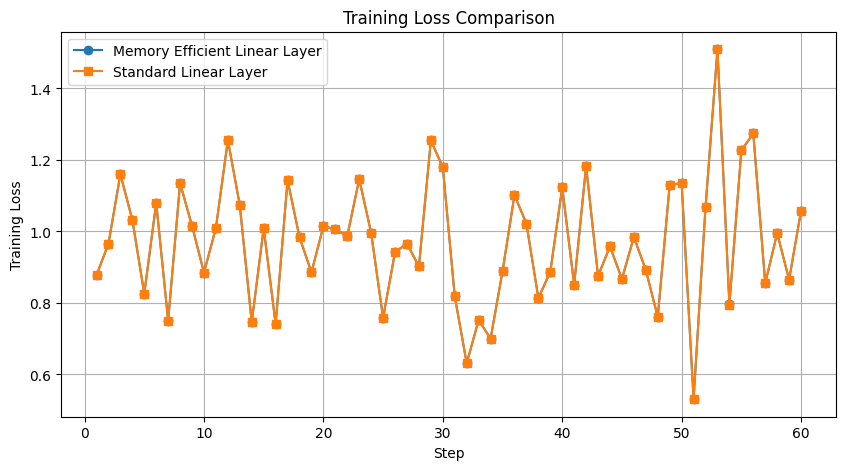

In [25]:
import matplotlib.pyplot as plt

steps1 = list(range(1, len(llama32_1b_training_loss_memory_efficient) + 1))
steps2 = list(range(1, len(llama32_1b_training_loss_standard) + 1))

plt.figure(figsize=(10, 5))
plt.plot(steps1, llama32_1b_training_loss_memory_efficient, marker='o', label='Memory Efficient Linear Layer')
plt.plot(steps2, llama32_1b_training_loss_standard, marker='s', label='Standard Linear Layer')
plt.xlabel('Step')
plt.ylabel('Training Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True)
plt.show()

**Observe that the lines are exactly matching, meaning the losses are the exact same.**

### GRPO Memory Efficient Linear
I replaced the lm head in the Unsloth GRPO training notebook and ran the training for 1 iteration. Then compared the output logits for fake input data, using torch.allclose.

In [28]:
# Memory efficient implementation logits

# Colab: https://colab.research.google.com/drive/1W6ybjwvgdm3zUrq3jFD54tFJOA-lfIcz?usp=sharing
# Github: https://github.com/RohitNagraj/UnslothPuzzles/blob/main/resources/q5/Llama_3_1_8B_GRPO_Memory_Efficient.ipynb

memory_efficient_logits = torch.load('resources/q5/logits_memory_efficient.pt', weights_only=False)

# Standard implementation logits

# Colab: https://colab.research.google.com/drive/1WvcrYgtNubYCB1S-EJg4qJEB5ysJ7K3m?usp=sharing
# Github: https://github.com/RohitNagraj/UnslothPuzzles/blob/main/resources/q5/Llama_3_1_8B_GRPO_Standard.ipynb

standard_logits = torch.load('resources/q5/logits_standard.pt', weights_only=False)

print("Torch.allclose: ", torch.allclose(memory_efficient_logits.logits, standard_logits.logits))

Torch.allclose:  True


In [29]:
def scoring():
    global final_score
    E_score = 0

    print(f"✅ VRAM 50% reduction: E_score += 2")
    E_score += 2

    print(f"✅ Show cross-entropy loss works: E_score += 1")
    E_score += 1

    print(f"✅ Show other loss functions works: E_score += 1")
    E_score += 1

    print(f"✅ Allow dynamic chunk sizes (See the forward definition of MemoryEfficientLinear): E_score += 1")
    E_score += 1

    print(f"✅ Llama 3.2 1B training loss values match across all steps: E_score += 1")
    E_score += 1

    print(f"❌ GRPO memory efficient loss working: E_score += 4")
    # E_score += 4

    final_score += E_score

    print(f"Final score: {final_score}")
scoring()

✅ VRAM 50% reduction: E_score += 2
✅ Show cross-entropy loss works: E_score += 1
✅ Show other loss functions works: E_score += 1
✅ Allow dynamic chunk sizes (See the forward definition of MemoryEfficientLinear): E_score += 1
✅ Llama 3.2 1B training loss values match across all steps: E_score += 1
❌ GRPO memory efficient loss working: E_score += 4
Final score: 19


## Marking Criteria for E) Max points = 10
```python
if attemped_E:
    E_score = 0
    if VRAM_50_percent_reduction: E_score += 2
    if remove_float32_upcast: E_score = 0
    if show_ce_loss_works: E_score += 1
    if show_other_functions_work: E_score += 1
    if hardcoded_gradients: E_score = 0
    if allows_dynamic_chunk_sizes: E_score += 1
    if llama_1B_training_loss_matches: E_score += 1
    else: E_score = 0
    if GRPO_memory_efficient_linear_works: E_score += 4
    final_score += E_score
else:
    final_score += 0
```

---
---
---
<a name="SUBMISSION"></a>
## Submission Steps

1. All code should be in a public Github (Apache 2 Licensed)
2. Kaggle notebooks and Colab notebooks should be linked in the README, and can be accessible through Colab / Kaggle.
3. If attaching notebooks, must attach fully run ones - do not just add a notebook without running it. Kaggle notebook must be public, and run.
4. Submit the Github to https://forms.gle/crSYnsGq3t1ck5TB9 If you want to send a private repo, please add me as a Github collaborate @danielhanchen
5. Provide screenshots, graphs, plots, etc especially for training loss curves.
6. We will comment and respond inside your Github repo. There will get 1 interview as well as a final step!

### Clarifications:
1. We'll compensate you if we interview you but don't hire you
2. \$100-\$1000 bounties for Task 4
3. Submissions must be Apache-2 licensed
4. Task 4 involves solving Github issues for OSS Unsloth
5. No time limit: rolling basis
6. US based preferred